In [1]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

/Users/kimhyunwoo/.pyenv/versions/3.8.6/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
tokenizer_config.json: 100%|██████████| 974/974 [00:00<00:00, 199kB/s]
vocab.json: 100%|██████████| 1.06M/1.06M [00:00<00:00, 2.01MB/s]
merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 1.32MB/s]
special_tokens_map.json: 100%|██████████| 472/472 [00:00<00:00, 88.0kB/s]
config.json: 100%|██████████| 4.73k/4.73k [00:00<00:00, 335kB/s]
pytorch_model.bin: 100%|██████████| 603M/603M [00:16<00:00, 37.7MB/s] 


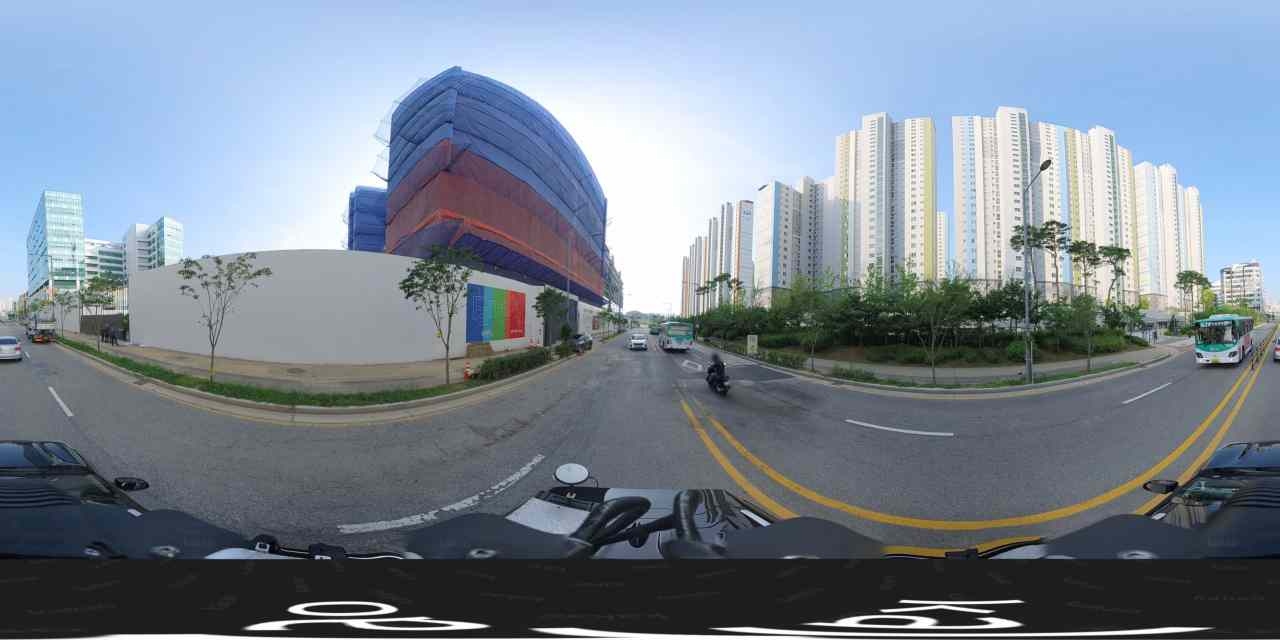

In [74]:
from PIL import Image

image = Image.open("img/pano_2.png")
image

In [99]:
# 세그먼트할 텍스트 카테고리 정의
prompts = ["sidewalk", "road", "building", "tree"]

In [100]:
import torch

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")
# predict
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

[Text(0, -15, 'sidewalk'),
 Text(0, -15, 'road'),
 Text(0, -15, 'building'),
 Text(0, -15, 'tree')]

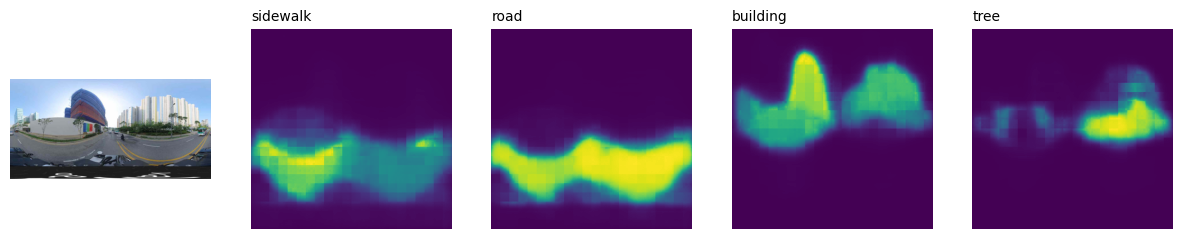

In [101]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))]
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)]

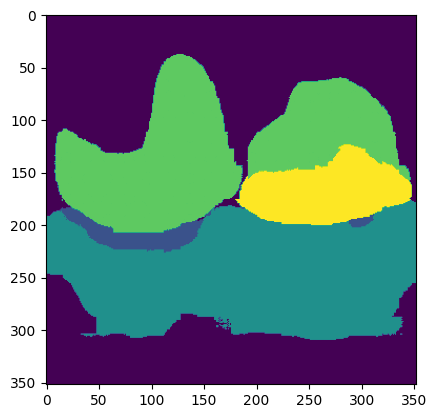

In [103]:
threshold = 0.2

flat_preds = torch.sigmoid(preds.squeeze()).reshape((preds.shape[0], -1))

# Initialize a dummy "unlabeled" mask with the threshold
flat_preds_with_treshold = torch.full((preds.shape[0] + 1, flat_preds.shape[-1]), threshold)
flat_preds_with_treshold[1:preds.shape[0]+1,:] = flat_preds

# Get the top mask index for each pixel
inds = torch.topk(flat_preds_with_treshold, 1, dim=0).indices.reshape((preds.shape[-2], preds.shape[-1]))

plt.imshow(inds)